# Preparation of raw data for encoding task (vim-2)

__Contents:__
- <a href="#overview">Overview of the data set</a>
- <a href="#stim_check">Stimulus: checking original data</a>
- <a href="#stim_ds">Stimulus: spatial down-sampling</a>
- <a href="#stim_hdf5">Stimulus: making new hierarchical file</a>
- <a href="#resp_check">BOLD Response: checking original data</a>
- <a href="#resp_hdf5">BOLD Response: making new hierarchical file</a>
- <a href="#preproc">Regarding pre-processing of responses</a>

We shall have two categorically distinct kinds of data: visual stimulus in the form of natural movies, and blood oxygen level-dependent (BOLD) signals measured using functional magnetic resonance imaging (fMRI), as an indicator of brain activity.

<img src="img/stimuli_ex.png" alt="Stimuli Image" width="240" height="180" />

<img src="img/fMRI_example.png" alt="fMRI Image" width="240" height="180" />

Our chief goal will be to create a working *encoder*, which predicts brain activity based on the contents of visual stimulus.

<a id="overview"></a>
## Overview of the data set

The data set of interest, called "Gallant Lab Natural Movie 4T fMRI Data set" (*vim-2*) contains the following types of data (of interest to us today):

__Stimuli__
```
Stimuli.tar.gz 4089110463 (3.8 GB)
```

__BOLD response__
```
VoxelResponses_subject1.tar.gz 3178624411 (2.9 GB)
VoxelResponses_subject2.tar.gz 3121761551 (2.9 GB)
VoxelResponses_subject3.tar.gz 3216874972 (2.9 GB)
```

All stimuli are stored in the `Stimuli.mat` file, Matlab v.7.3 format. Variables take the following forms.

 - `st`: training stimuli. 128x128x3x108000 matrix (108000 128x128 rgb frames). 
 - `sv`: validation stimuli. 128x128x3x8100 matrix (8100 128x128 rgb frames).

For the training data, stimulus was presented at 15fps over 7200 timepoints = 120 minutes, for a total of 108000 frames. For the validation data, stimulus was presented at 15fps over 540 timepoints = 9 minutes for a total of 8100 frames.

The validation stimulus was presented a total of ten times to each subject, and the response values used above correspond to the average taken over these trials. The "raw" validation response values (pre-averaging) are available, but the mean values serve our purposes just fine.

Finally, no re-arranging of the data is required, fortunately. The authors note:

> *"The order of the stimuli in the "st" and "sv" variables matches the order of the stimuli in the "rt" and "rv" variables in the response files."*

Moving forward, the first task is to decompress the data.

```
$ tar -xzf Stimuli.tar.gz
$ tar -xzf VoxelResponses_subject1.tar.gz
$ tar -xzf VoxelResponses_subject2.tar.gz
$ tar -xzf VoxelResponses_subject3.tar.gz
```

This leaves us with files `Stimuli.mat` and `VoxelResponses_subject{1,2,3}.mat`. Our key tool of use here will be the __PyTables__ library (http://www.pytables.org/usersguide/index.html), which is convenient for hierarchical data. To see what is stored in the data (and corroborate with the documentation), run the following.

```
$ ptdump Stimuli.mat
/ (RootGroup) ''
/st (EArray(108000, 3, 128, 128), zlib(3)) ''
/sv (EArray(8100, 3, 128, 128), zlib(3)) ''
```

Note the coordinates. There is not much of a hierarchy here, just two folders in the root group. Note the order of the dimensions; dim 1 is the observation index, dim 2 is the RGB channel, and dims 3 and 4 specify pixel position in an array.

The response data has a richer structure.

```
$ ptdump VoxelResponses_subject1.mat 
/ (RootGroup) ''
/rt (EArray(73728, 7200), zlib(3)) ''
/rv (EArray(73728, 540), zlib(3)) ''
/rva (EArray(73728, 10, 540), zlib(3)) ''
(...Warnings...)
/ei (Group) ''
/ei/TRsec (Array(1, 1)) ''
/ei/datasize (Array(3, 1)) ''
/ei/imhz (Array(1, 1)) ''
/ei/valrepnum (Array(1, 1)) ''
/roi (Group) ''
/roi/FFAlh (EArray(18, 64, 64), zlib(3)) ''
/roi/FFArh (EArray(18, 64, 64), zlib(3)) ''
/roi/IPlh (EArray(18, 64, 64), zlib(3)) ''
/roi/IPrh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTlh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTplh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTprh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTrh (EArray(18, 64, 64), zlib(3)) ''
/roi/OBJlh (EArray(18, 64, 64), zlib(3)) ''
/roi/OBJrh (EArray(18, 64, 64), zlib(3)) ''
/roi/PPAlh (EArray(18, 64, 64), zlib(3)) ''
/roi/PPArh (EArray(18, 64, 64), zlib(3)) ''
/roi/RSCrh (EArray(18, 64, 64), zlib(3)) ''
/roi/STSrh (EArray(18, 64, 64), zlib(3)) ''
/roi/VOlh (EArray(18, 64, 64), zlib(3)) ''
/roi/VOrh (EArray(18, 64, 64), zlib(3)) ''
/roi/latocclh (EArray(18, 64, 64), zlib(3)) ''
/roi/latoccrh (EArray(18, 64, 64), zlib(3)) ''
/roi/v1lh (EArray(18, 64, 64), zlib(3)) ''
/roi/v1rh (EArray(18, 64, 64), zlib(3)) ''
/roi/v2lh (EArray(18, 64, 64), zlib(3)) ''
/roi/v2rh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3alh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3arh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3blh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3brh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3lh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3rh (EArray(18, 64, 64), zlib(3)) ''
/roi/v4lh (EArray(18, 64, 64), zlib(3)) ''
/roi/v4rh (EArray(18, 64, 64), zlib(3)) ''

```

Within the root group, we have arrays `rt`, `rv`, and `rva` which contain BOLD response data, group `roi` which contains arrays used as indices for assigning particular responses to particular voxels, and group `ei` which stores pertinent experimental information. In particular, under the `roi` group there are numerous arrays named according to anatomical/functional regions of interest (ROI). For example, `v4rh` corresponds to the __V4__ region in the __l__eft __h__emisphere. Since there are far less ROIs than there are voxels $18 \times 64 \times 64 = 73728$, note that each region is composed of many voxels.

<a id="stim_check"></a>
## Stimulus: checking original data

Let's begin by taking a look inside the stimulus.

In [1]:
import numpy as np
import tables
import matplotlib
from matplotlib import pyplot as plt
import pprint as pp

# Open file connection.
f = tables.open_file("data/vim-2/Stimuli.mat", mode="r")

# Get object and array.
stimulus_object = f.get_node(where="/", name="st")
print("stimulus_object:")
print(stimulus_object)
print(type(stimulus_object))
print("----")

stimulus_array = stimulus_object.read()
print("stimulus_array:")
#print(stimulus_array)
print(type(stimulus_array))
print("----")

# Close the connection.
f.close()

# Check that it is closed.
if not f.isopen:
    print("Successfully closed.")
else:
    print("File connection is still open.")


stimulus_object:
/st (EArray(108000, 3, 128, 128), zlib(3)) ''
<class 'tables.earray.EArray'>
----
stimulus_array:
<class 'numpy.ndarray'>
----
Successfully closed.


Let's inspect the content of this array to ensure it has what we expect.

In [2]:
# Open file connection.
f = tables.open_file("data/vim-2/Stimuli.mat", mode="r")

In [3]:
# Get object and array.
stimulus_object = f.get_node(where="/", name="st")
print("stimulus_object:")
print(stimulus_object)
print(type(stimulus_object))
print("----")

stimulus_object:
/st (EArray(108000, 3, 128, 128), zlib(3)) ''
<class 'tables.earray.EArray'>
----


In [4]:
# Print out basic attributes.
stimulus_array = stimulus_object.read()
#print("stimulus_array:")
#print(stimulus_array)
print("(type)")
print(type(stimulus_array))
print("(dtype)")
print(stimulus_array.dtype)
print("----")

(type)
<class 'numpy.ndarray'>
(dtype)
uint8
----


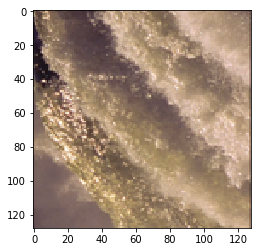

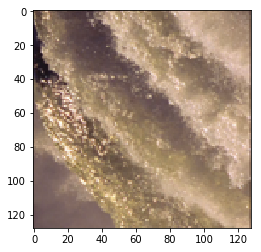

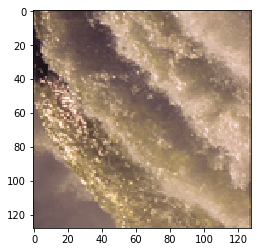

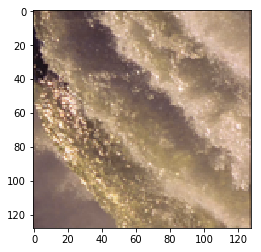

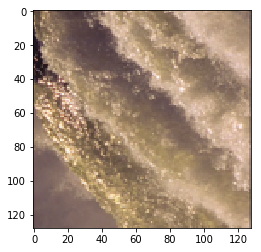

In [5]:
# Print out some frames.
num_frames = stimulus_array.shape[0]
num_channels = stimulus_array.shape[1]
frame_w = stimulus_array.shape[2]
frame_h = stimulus_array.shape[3]

frames_to_play = 5

oneframe = np.zeros(num_channels*frame_h*frame_w, dtype=np.uint8).reshape((frame_h, frame_w, num_channels))
im = plt.imshow(oneframe)

for t in range(frames_to_play):
    oneframe[:,:,0] = stimulus_array[t,0,:,:] # red
    oneframe[:,:,1] = stimulus_array[t,1,:,:] # green
    oneframe[:,:,2] = stimulus_array[t,2,:,:] # blue
    plt.imshow(oneframe)
    plt.show()



In [6]:
# Close file connection.
f.close()

Anyways, clearly the content is roughly as we would expect (a series of video clips), although the orientation is incorrect, and the framerate is much higher than the sampling rate of the responses we'll be working with.

### Exercises (A):

0. Swap the coordinates (see `help(np.swapaxes)`) to fix the orientation.

0. In addition to the first handful of frames, check the *last* handful of frames to ensure that the content is as we expect.

0. Repeat the visualization procedure above for `st` (the training data) to ensure it is also as we expect.

0. Do the above procedures for the first 100 frames. Note that the current framerate is 15fps. By modifying the `for` loop above, using `np.arange` instead of `range`, we can easily "down-sample" to a lower temporal frequency. Try downsampling to a rate of 1fps (by displaying one out of every fifteen frames).

<a id="stim_ds"></a>
## Stimulus: spatial down-sampling

For computational purposes, it is advisable to spatially down-sample the stimulus data, in addition to the temporal down-sampling required to align it with the BOLD signal responses (this can be done later). Here we carry out the spatial down-sampling. Using the function `resize` from the `transform` module of __scikit-image__, this can be done easily. First, a simple test.

In [2]:
from skimage import transform
from matplotlib import pyplot as plt
import imageio
import tables
import numpy as np

im = imageio.imread("img/bishop.png") # a 128px x 128px image

In [3]:
med_h = 96 # desired height in pixels
med_w = 96 # desired width in pixels
im_med = transform.resize(image=im, output_shape=(med_h,med_w), mode="reflect")

small_h = 32
small_w = 32
im_small = transform.resize(image=im, output_shape=(small_h,small_w), mode="reflect")

tiny_h = 16
tiny_w = 16
im_tiny = transform.resize(image=im, output_shape=(tiny_h,tiny_w), mode="reflect")

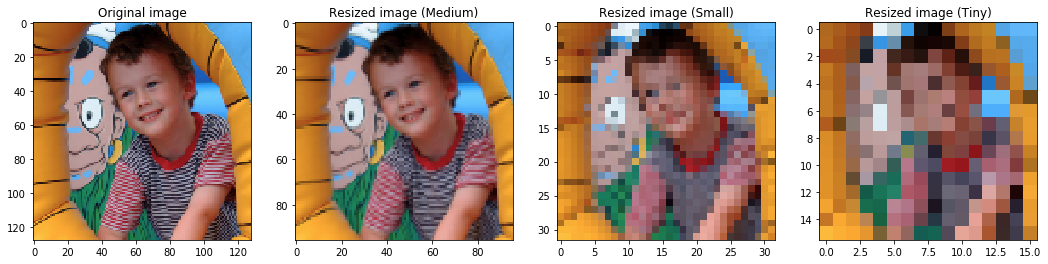

In [4]:
myfig = plt.figure(figsize=(18,4))

ax_im = myfig.add_subplot(1,4,1)
plt.imshow(im)
plt.title("Original image")
ax_med = myfig.add_subplot(1,4,2)
plt.imshow(im_med)
plt.title("Resized image (Medium)")
ax_small = myfig.add_subplot(1,4,3)
plt.imshow(im_small)
plt.title("Resized image (Small)")
ax_small = myfig.add_subplot(1,4,4)
plt.imshow(im_tiny)
plt.title("Resized image (Tiny)")

plt.show()

Everything appears to be working as expected. Let us now do this for the entire set of visual stimulus.

In [5]:
# Open file connection.
f = tables.open_file("data/vim-2/Stimuli.mat", mode="r")

In [6]:
# Specify which subset to use.
touse_subset = "sv" 

In [7]:
# Get object, array, and properties.
stimulus_object = f.get_node(where="/", name=touse_subset)
stimulus_array = stimulus_object.read()
num_frames = stimulus_array.shape[0]
num_channels = stimulus_array.shape[1]

In [8]:
# Swap the axes.
print("Stimulus array (before):", stimulus_array.shape)
stimulus_array = np.swapaxes(a=stimulus_array, axis1=0, axis2=3)
stimulus_array = np.swapaxes(a=stimulus_array, axis1=1, axis2=2)
print("Stimulus array (after):", stimulus_array.shape)

Stimulus array (before): (8100, 3, 128, 128)
Stimulus array (after): (128, 128, 3, 8100)


In [9]:
# Prepare new array of downsampled stimulus.
ds_h = 64
ds_w = 64

new_array = np.zeros(num_frames*num_channels*ds_h*ds_w, dtype=np.float32)
new_array = new_array.reshape((ds_h, ds_w, num_channels, num_frames))

In [10]:
# Iterate over frames to be resized.
for t in range(num_frames):
    new_array[:,:,:,t] = transform.resize(image=stimulus_array[:,:,:,t],
                                          output_shape=(ds_h,ds_w),
                                          mode="reflect")
    if t % 1000 == 0:
        print("Update: t =", t)
        
f.close()

Update: t = 0
Update: t = 1000
Update: t = 2000
Update: t = 3000
Update: t = 4000
Update: t = 5000
Update: t = 6000
Update: t = 7000
Update: t = 8000


Note that resizing the images yields pixel values on $[0,1]$ rather than $\{0,1,\ldots,255\}$, which is why we set the `dtype` to `np.float32`:

In [12]:
print("(Pre-downsize) max:", np.max(stimulus_array),
      "min:", np.min(stimulus_array),
      "ave:", np.mean(stimulus_array))
print("(Post-downsize) max:", np.max(new_array),
      "min:", np.min(new_array),
      "ave:", np.mean(new_array))

(Pre-downsize) max: 255 min: 0 ave: 90.50942391854745
(Post-downsize) max: 1.0 min: 0.0 ave: 0.3549391


Let's now save this as a binary file for fast reading/writing.

In [13]:
fname = "data/vim-2/" + str(touse_subset) + "_downsampled.dat"
with open(fname, mode="bw") as fbin:
    new_array.tofile(fbin)

fname = "data/vim-2/" + str(touse_subset) + "_downsampled.info"
with open(fname, mode="w") as f:
    f.write("dtype: "+str(new_array.dtype)+"\n")
    f.write("shape: "+str(new_array.shape)+"\n")

### Exercises (B):

0. Repeat the above down-sampling and writing to disk for `st`, the training data.

0. Try some extremely small versions, such as 32x32, 16x16, and so on. What do you think the potential benefits are of doing this? What about potential drawbacks?

To ensure that everything worked as desired, we would like to load up these arrays to check that everything has been saved correctly. First, check the dimensions we saved:

In [1]:
! cat data/vim-2/st_downsampled.info
! cat data/vim-2/sv_downsampled.info

cat: data/vim-2/st_downsampled.info: No such file or directory
cat: data/vim-2/sv_downsampled.info: No such file or directory


Then plugging these values in below, we can check that the contents are indeed as we expect.

Training data:


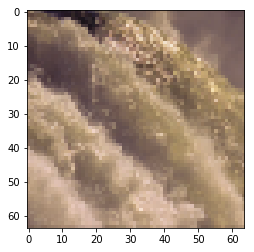

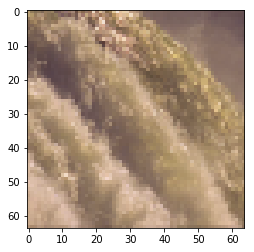

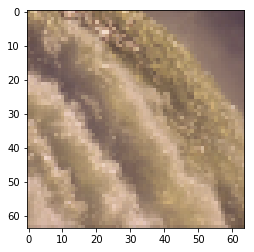

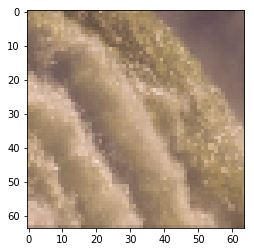

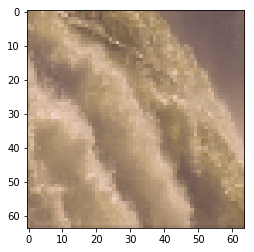

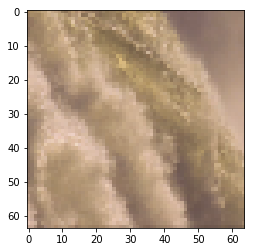

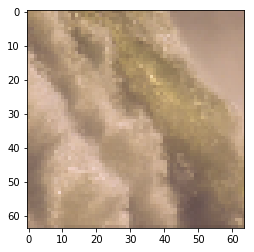

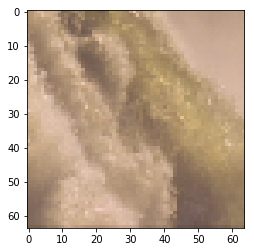

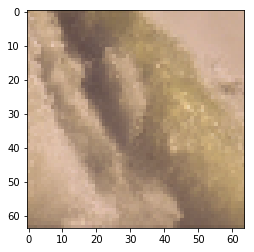

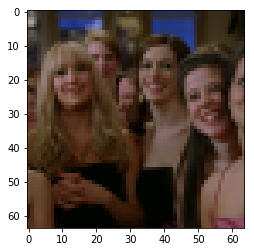

In [23]:
print("Training data:")
fname = "data/vim-2/" + "st" + "_downsampled.dat"
with open(fname, mode="br") as fbin:
    
    # Read array.
    arr_tocheck = np.fromfile(file=fbin, dtype=np.float32).reshape((64, 64, 3, 108000))

    # Check a few frames.
    num_frames = arr_tocheck.shape[3]
    frames_to_play = 10
    for t in np.arange(0, frames_to_play*15, 15):
        plt.imshow(arr_tocheck[:,:,:,t])
        plt.show()

Testing data:


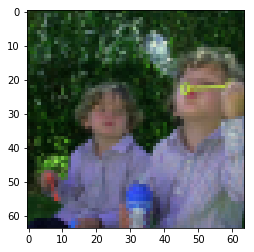

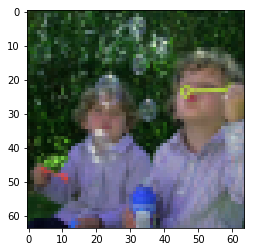

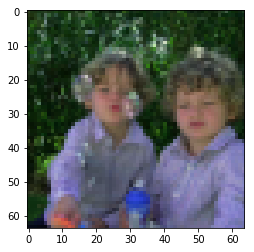

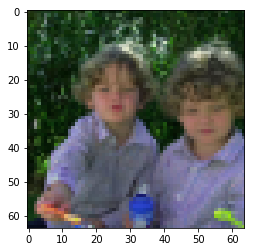

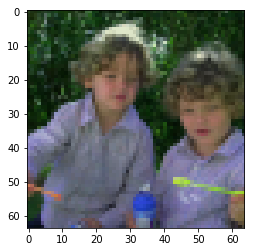

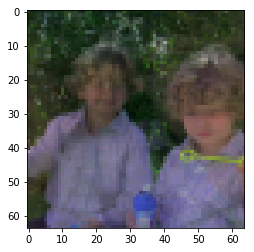

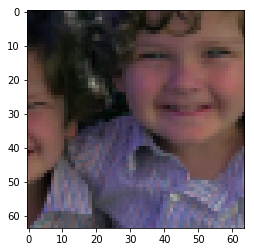

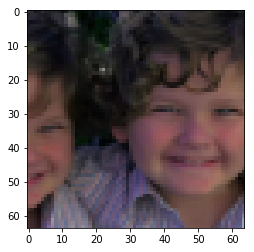

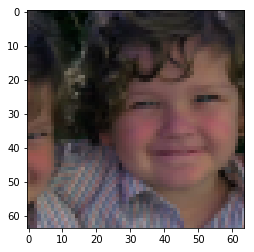

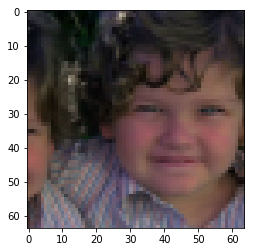

In [25]:
print("Testing data:")
fname = "data/vim-2/" + "sv" + "_downsampled.dat"
with open(fname, mode="br") as fbin:
    
    # Read array.
    arr_tocheck = np.fromfile(file=fbin, dtype=np.float32).reshape((64, 64, 3, 8100))

    # Check a few frames.
    num_frames = arr_tocheck.shape[3]
    frames_to_play = 10
    for t in np.arange(0, frames_to_play*15, 15):
        plt.imshow(arr_tocheck[:,:,:,t])
        plt.show()

<a id="stim_hdf5"></a>
## Stimulus: making new hierarchical file

Let's make a new hierarchical data set containing our sub-sampled stimulus.

In [37]:
import tables
import numpy as np

# Open file connection, writing new file to disk.
myh5 = tables.open_file("data/vim-2/stimulus_ds.h5",
                        mode="w",
                        title="vim-2: stimulus")
print(myh5)

data/vim-2/stimulus_ds.h5 (File) 'vim-2: stimulus'
Last modif.: 'Tue Mar 27 21:14:24 2018'
Object Tree: 
/ (RootGroup) 'vim-2: stimulus'



In [38]:
# Load up our downsampled stimulus (training).
fname = "data/vim-2/" + "st" + "_downsampled.dat"
with open(fname, mode="br") as fbin:
    arr = np.fromfile(file=fbin, dtype=np.float32).reshape((64, 64, 3, 108000))
    
myh5.create_array(where=myh5.root, name="train", obj=arr, title="Training data")
print(myh5)

data/vim-2/stimulus_ds.h5 (File) 'vim-2: stimulus'
Last modif.: 'Tue Mar 27 21:14:34 2018'
Object Tree: 
/ (RootGroup) 'vim-2: stimulus'
/train (Array(64, 64, 3, 108000)) 'Training data'



In [39]:
# Load up our downsampled stimulus (testing).
fname = "data/vim-2/" + "sv" + "_downsampled.dat"
with open(fname, mode="br") as fbin:
    arr = np.fromfile(file=fbin, dtype=np.float32).reshape((64, 64, 3, 8100))

myh5.create_array(where=myh5.root, name="test", obj=arr, title="Testing data")
print(myh5)

data/vim-2/stimulus_ds.h5 (File) 'vim-2: stimulus'
Last modif.: 'Tue Mar 27 21:14:42 2018'
Object Tree: 
/ (RootGroup) 'vim-2: stimulus'
/test (Array(64, 64, 3, 8100)) 'Testing data'
/train (Array(64, 64, 3, 108000)) 'Training data'



In [40]:
myh5.close()
print(myh5)

<closed File>


Since these files take up a lot of space, let's ensure we can do the same thing with this hierarchical data, and then clear out everything else.

In [52]:
myh5 = tables.open_file("data/vim-2/stimulus_ds.h5", mode="r")
print(myh5)
myh5.close()

data/vim-2/stimulus_ds.h5 (File) 'vim-2: stimulus'
Last modif.: 'Tue Mar 27 21:14:47 2018'
Object Tree: 
/ (RootGroup) 'vim-2: stimulus'
/test (Array(64, 64, 3, 8100)) 'Testing data'
/train (Array(64, 64, 3, 108000)) 'Training data'



/train (Array(64, 64, 3, 108000)) 'Training data'
<class 'tables.array.Array'>
(64, 64, 3, 10)


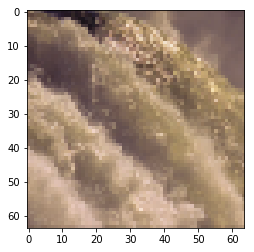

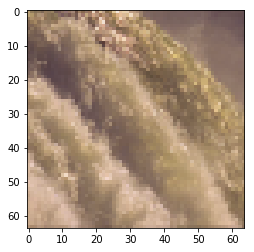

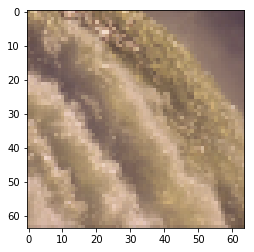

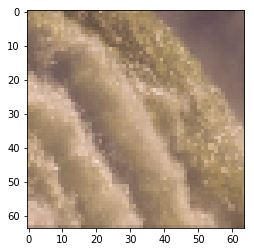

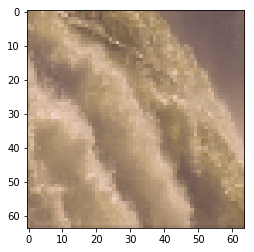

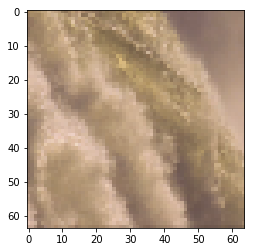

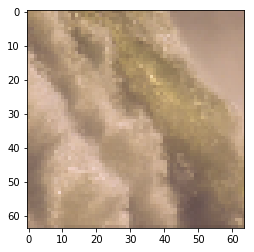

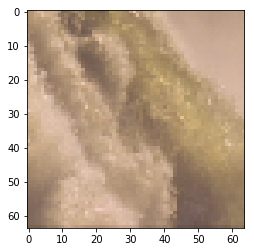

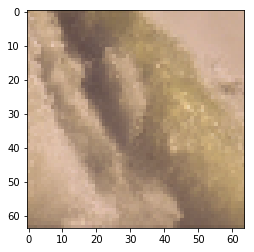

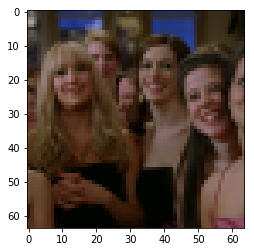

In [53]:
# Check the training data.
myh5 = tables.open_file("data/vim-2/stimulus_ds.h5", mode="r")
arrInst = myh5.get_node(myh5.root, "train")
print(arrInst)
print(type(arrInst))
frames_to_play = 10
idx = np.arange(0, frames_to_play*15, 15)
arr = arrInst[:,:,:,idx]
print(arr.shape)
for t in range(arr.shape[3]):
    plt.imshow(arr[:,:,:,t])
    plt.show()
myh5.close()

/test (Array(64, 64, 3, 8100)) 'Testing data'
<class 'tables.array.Array'>
(64, 64, 3, 10)


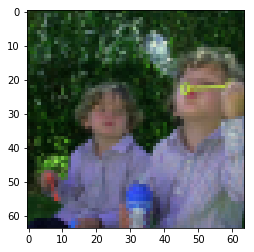

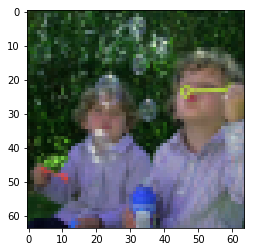

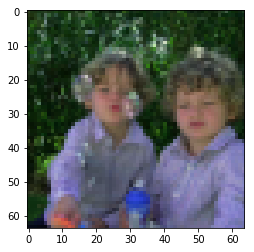

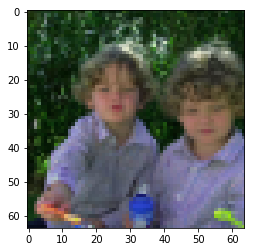

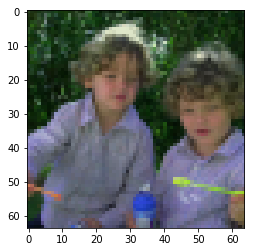

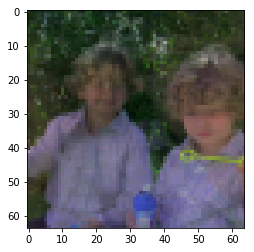

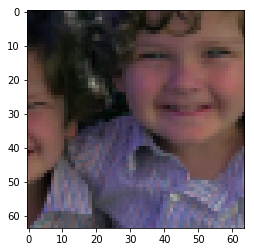

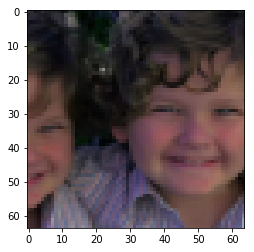

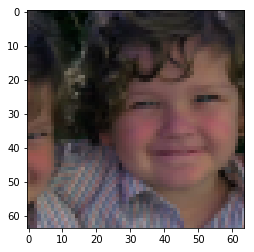

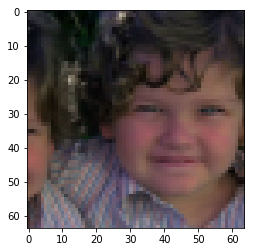

In [54]:
# Check the testing data.
myh5 = tables.open_file("data/vim-2/stimulus_ds.h5", mode="r")
arrInst = myh5.get_node(myh5.root, "test")
print(arrInst)
print(type(arrInst))
frames_to_play = 10
idx = np.arange(0, frames_to_play*15, 15)
arr = arrInst[:,:,:,idx]
print(arr.shape)
for t in range(arr.shape[3]):
    plt.imshow(arr[:,:,:,t])
    plt.show()
myh5.close()

Some points on PyTables classes: 

- The `Array` class assumes homogeneous data (in terms of the type), and does not allow for adding entries on the fly.

- The `EArray` class allows for enlargeable data sets (fixed size of entries, but unlimited ability to add entries).

- Using `Table` objects one can deal with heterogeneous data sets on the fly in a very smooth way.

For our purposes here, since we will not be adding any data, and each array is homogeneous (different array objects needn't have the same type of course), the `Array` class is the natural choice.

<a id="resp_check"></a>
## BOLD Response: checking original data

Next, we examine the response data.

In [2]:
import numpy as np
import tables
import matplotlib
from matplotlib import pyplot as plt
import pprint as pp

# Open file connection.
f = tables.open_file("data/vim-2/VoxelResponses_subject1.mat", mode="r")
print(f)

data/vim-2/VoxelResponses_subject1.mat (File) ''
Last modif.: 'Tue Apr  1 05:55:05 2014'
Object Tree: 
/ (RootGroup) ''
/rt (EArray(73728, 7200), zlib(3)) ''
/rv (EArray(73728, 540), zlib(3)) ''
/rva (EArray(73728, 10, 540), zlib(3)) ''
/ei (Group) ''
/ei/TRsec (Array(1, 1)) ''
/ei/datasize (Array(3, 1)) ''
/ei/imhz (Array(1, 1)) ''
/ei/valrepnum (Array(1, 1)) ''
/roi (Group) ''
/roi/FFAlh (EArray(18, 64, 64), zlib(3)) ''
/roi/FFArh (EArray(18, 64, 64), zlib(3)) ''
/roi/IPlh (EArray(18, 64, 64), zlib(3)) ''
/roi/IPrh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTlh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTplh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTprh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTrh (EArray(18, 64, 64), zlib(3)) ''
/roi/OBJlh (EArray(18, 64, 64), zlib(3)) ''
/roi/OBJrh (EArray(18, 64, 64), zlib(3)) ''
/roi/PPAlh (EArray(18, 64, 64), zlib(3)) ''
/roi/PPArh (EArray(18, 64, 64), zlib(3)) ''
/roi/RSCrh (EArray(18, 64, 64), zlib(3)) ''
/roi/STSrh (EArray(18, 64, 64), zlib(3)) ''
/roi/V

/home/mjh/anaconda3/lib/python3.6/site-packages/tables/attributeset.py:299: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'ei'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)
/home/mjh/anaconda3/lib/python3.6/site-packages/tables/attributeset.py:299: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'roi'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


In [3]:
# Get the EArray objects (from tables)
roi_tocheck = "v4lh"
response_object = f.get_node(where="/", name="rt")
idx_object = f.get_node(where="/roi/", name=roi_tocheck)

print("response_object:")
print(response_object)
print(type(response_object))
print("----")
print("idx_object:")
print(idx_object)
print(type(idx_object))
print("----")

response_object:
/rt (EArray(73728, 7200), zlib(3)) ''
<class 'tables.earray.EArray'>
----
idx_object:
/roi//v4lh (EArray(18, 64, 64), zlib(3)) ''
<class 'tables.earray.EArray'>
----


/home/mjh/anaconda3/lib/python3.6/site-packages/tables/attributeset.py:299: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node ''. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


In [4]:
# Get numpy arrays.
response_array = response_object.read()
idx_array = idx_object.read()

print("response_array:")
print(type(response_array))
print(response_array.shape)
print(response_array.dtype)
print("----")
print("idx_array:")
print(type(idx_array))
print(idx_array.shape)
print(idx_array.dtype)
print("----")

response_array:
<class 'numpy.ndarray'>
(73728, 7200)
float32
----
idx_array:
<class 'numpy.ndarray'>
(18, 64, 64)
float64
----


In [5]:
# Close the connection.
f.close()

Note the important connection here: the first index of the response array has length 73728 = 18 x 64 x 64, one element for each *voxel*. The "index" array is called such because it lets us take subsets of voxels corresponding to distinct ROIs.

To see how this is done, let's examine the contents of a particular index array.

In [6]:
pp.pprint(idx_array[0:2, 0:5,0:5])
print("dtype:", idx_array.dtype)
print("unique:", np.unique(idx_array))
print("sum =", np.sum(idx_array))

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])
dtype: float64
unique: [0. 1.]
sum = 308.0


While the values are of `np.float64` type, clearly they are just indicators of which cells in a 18 x 64 x 64 array are included in the ROI we specified in `roi_tocheck`.

### Exercises (C):

0. Use `np.nonzero` to get the actual indices that are "hot".

0. How many voxels are there in the ROI called V4 in the left hemisphere?

0. How many voxels are in V4 in total? (both left and right hemispheres)

0. Is this number the same across all subjects?

0. Try summing the contents of all the index matrices. If the sum is precisely 73728 (the number of voxels), then it is reasonable to expect that each voxel appears in one and only one ROI. If the sum is less than this number, some voxels necessarily do not belong to any ROIs. If the sum is greater that this number, some voxels must belong to more than one ROI. Which of these is the case?

0. Make a bar graph (see `help(plt.bar)`) for each region. Which region is largest? Smallest? Is there a difference between left/right hemispheres, or are they symmetric?

Let's now make use of these indices for taking ROI-wise subsets.

In [7]:
with tables.open_file("data/vim-2/VoxelResponses_subject1.mat", mode="r") as f:
    
    response_object = f.get_node(where=f.root, name="rt")
    
    # Extract EArray, the numpy array.
    idx_object = f.get_node(where="/roi/", name=roi_tocheck)
    idx_array = idx_object.read()
    
    # Get a flat vector of index values.
    indices = np.nonzero(idx_array.flatten())[0]
    
    # Extract a subset; take from the 0th axis the specified indices.
    response_subset = np.take(a=response_object.read(),
                              axis=0,
                              indices=indices)
    print("shape:", response_subset.shape)
    print("dtype:", response_subset.dtype)
    print("type:", type(response_subset))
    print("sum of index:", np.sum(idx_array))

shape: (308, 7200)
dtype: float32
type: <class 'numpy.ndarray'>
sum of index: 308.0


Let's visualize the output of the first few voxels.

Voxel number: 0
num of nans: 0
Voxel number: 1
num of nans: 0
Voxel number: 2
num of nans: 0
Voxel number: 3
num of nans: 0


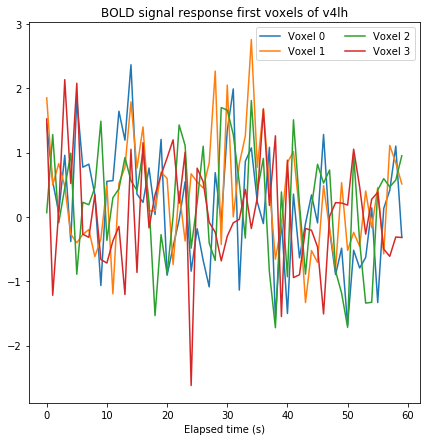

In [8]:
num_voxels = 4
num_secs = 60
time_idx = np.arange(0, num_secs, 1)

myfig = plt.figure(figsize=(7,7))
ax_1 = myfig.add_subplot(1,1,1)
plt.title(("BOLD signal response first voxels of "+roi_tocheck))
for v in range(num_voxels):
    val = response_subset[v,time_idx]
    ax_1.plot(time_idx, val, label=("Voxel "+str(v)))
    print("Voxel number:", v)
    print("num of nans:", np.sum(np.isnan(val)))

ax_1.legend(loc=1,ncol=2)
plt.xlabel("Elapsed time (s)")
plt.show()

The responses are rather erratic, but at least appear to be correctly read.

From here, we shall focus on a particular subset of voxels for our training task, that satisfies the following two conditions:

- Includes no missing values.

- Falls into the "early visual areas" specified by Nishimoto *et al.* (2011), namely __V1__, __V2__, __V3__, __V3A__, __V3B__ in the __left__ and __right__ hemispheres.

In [9]:
# As an illustrative example, let's find the clean indices.
with tables.open_file("data/vim-2/VoxelResponses_subject1.mat", mode="r") as f:
    
    response_object = f.get_node(where=f.root, name="rt")
    response_array = response_object.read()
    
    num_voxels = response_array.shape[0]
    
    count_numerical = 0
    count_nan = 0
    
    for v in range(num_voxels):
        tocheck = np.isnan(response_array[v,:])
        sumcheck = np.sum(tocheck)
        if (sumcheck > 0):
            count_nan += 1
        else:
            count_numerical += 1

    print("Number of clean voxels:", count_numerical)
    print("Number of bad voxels:", count_nan)

Number of clean voxels: 59928
Number of bad voxels: 13800


There's a rather large number of bad voxels; let's see how many of them coincide with the ROIs.

/home/mjh/anaconda3/lib/python3.6/site-packages/tables/attributeset.py:299: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'roi'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


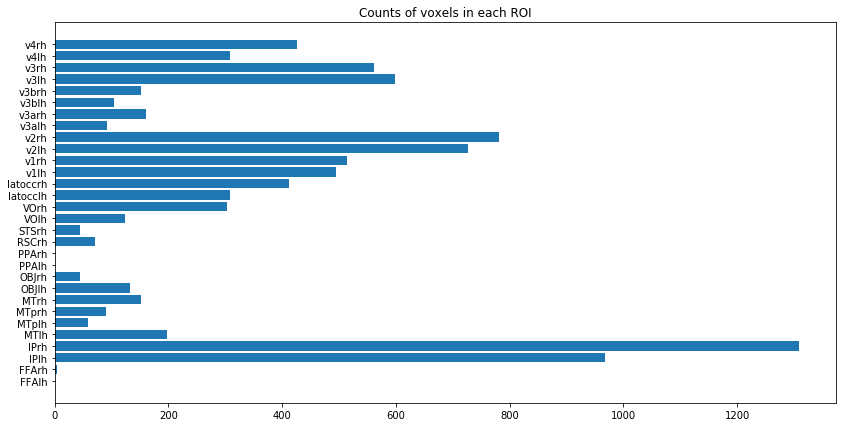

1308
0
9137


In [12]:
# First, let's iterate over the names.
with tables.open_file("data/vim-2/VoxelResponses_subject1.mat", mode="r") as f:
    
    roi_counts = {}
    for roi in f.root.roi._f_iter_nodes():
        countval = np.sum(roi.read(), dtype=np.uint32)
        roi_counts[roi._v_name] = countval

# Plot the counts.
xvals = list(roi_counts.keys())
yvals = list(roi_counts.values())
myfig = plt.figure(figsize=(14,7))
plt.barh(range(len(roi_counts)), yvals)
plt.yticks(range(len(roi_counts)), xvals)
plt.title("Counts of voxels in each ROI")
plt.show()

print(max(yvals))
print(min(yvals))
print(sum(yvals))

# For later reference, hold on to this dictionary.
roi_counts_raw = roi_counts

/home/mjh/anaconda3/lib/python3.6/site-packages/tables/attributeset.py:299: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'roi'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


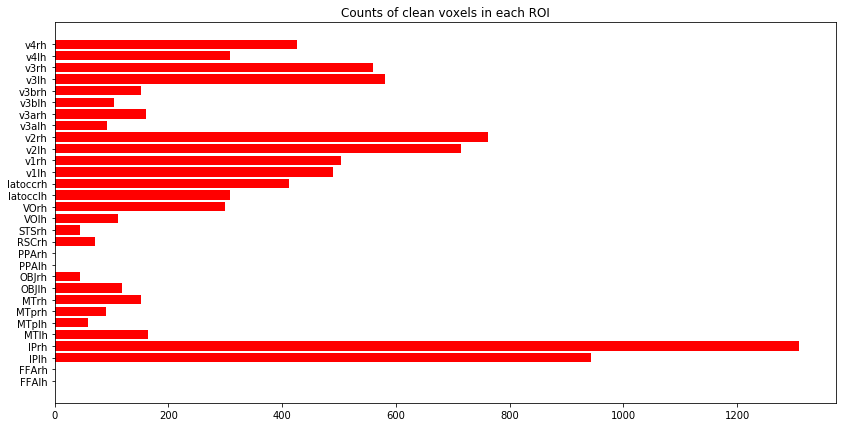

1308
0
8982


In [13]:
# Let's do the same thing, but with the added check for missing values.
with tables.open_file("data/vim-2/VoxelResponses_subject1.mat", mode="r") as f:
    
    response_array = f.get_node(f.root, "rt")
    
    roi_counts = {}
    for roi in f.root.roi._f_iter_nodes():
        
        indices = np.nonzero(roi.read().flatten())[0]
        count_nan = 0
        count_numerical = 0
        
        for v in indices:
            tocheck = np.isnan(response_array[v,:])
            sumcheck = np.sum(tocheck)
            if (sumcheck > 0):
                count_nan += 1
            else:
                count_numerical += 1
                
        roi_counts[roi._v_name] = count_numerical

# Plot the counts.
xvals = list(roi_counts.keys())
yvals = list(roi_counts.values())
myfig = plt.figure(figsize=(14,7))
plt.barh(range(len(roi_counts)), yvals, color="red")
plt.yticks(range(len(roi_counts)), xvals)
plt.title("Counts of clean voxels in each ROI")
plt.show()

print(max(yvals))
print(min(yvals))
print(sum(yvals))

# For later reference, hold on to this dictionary.
roi_counts_clean = roi_counts

In [14]:
# Now let's compare the two more directly.
for v in roi_counts_raw.keys():
    print("ROI:", v,
          "raw:", roi_counts_raw[v],
          "clean:", roi_counts_clean[v])

ROI: FFAlh raw: 0 clean: 0
ROI: FFArh raw: 5 clean: 0
ROI: IPlh raw: 967 clean: 943
ROI: IPrh raw: 1308 clean: 1308
ROI: MTlh raw: 197 clean: 165
ROI: MTplh raw: 58 clean: 58
ROI: MTprh raw: 91 clean: 91
ROI: MTrh raw: 152 clean: 152
ROI: OBJlh raw: 132 clean: 119
ROI: OBJrh raw: 44 clean: 44
ROI: PPAlh raw: 0 clean: 0
ROI: PPArh raw: 0 clean: 0
ROI: RSCrh raw: 71 clean: 71
ROI: STSrh raw: 45 clean: 45
ROI: VOlh raw: 124 clean: 111
ROI: VOrh raw: 304 clean: 299
ROI: latocclh raw: 309 clean: 309
ROI: latoccrh raw: 413 clean: 413
ROI: v1lh raw: 494 clean: 490
ROI: v1rh raw: 514 clean: 504
ROI: v2lh raw: 726 clean: 715
ROI: v2rh raw: 781 clean: 762
ROI: v3alh raw: 92 clean: 92
ROI: v3arh raw: 160 clean: 160
ROI: v3blh raw: 104 clean: 104
ROI: v3brh raw: 152 clean: 152
ROI: v3lh raw: 598 clean: 581
ROI: v3rh raw: 562 clean: 560
ROI: v4lh raw: 308 clean: 308
ROI: v4rh raw: 426 clean: 426


We thus can observe the following facts:

- Virtually all of the voxels assigned to any ROI are clean.

- The majority of voxels are not assigned to any ROI.

- There are ROI which do not have any voxels assigned to them (i.e., that region was not measured).

- There are some differences between the left/right hemispheres within the same subject.

<a id="resp_hdf5"></a>
## BOLD Response: making new hierarchical file

Let us proceed with making our own hierarchical data object, with just the useful voxels, and entries for all the subjects.

In [1]:
import tables
import numpy as np

# Open file connection, writing new file to disk.
myh5 = tables.open_file("data/vim-2/response.h5",
                        mode="w",
                        title="vim-2: BOLD responses")
print(myh5)

data/vim-2/response.h5 (File) 'vim-2: BOLD responses'
Last modif.: 'Mon Apr  9 09:13:12 2018'
Object Tree: 
/ (RootGroup) 'vim-2: BOLD responses'



In [2]:
num_subjects = 3
roi_list = ["v1lh", "v1rh",
            "v2lh", "v2rh",
            "v3lh", "v3rh",
            "v3alh", "v3arh",
            "v3blh", "v3brh"]

In [3]:
# Create all our groups, and fill in arrays while doing it.
for m in range(num_subjects):
    myname = "sub" + str(m+1)
    mytitle = "Data for subject " + str(m+1)
    
    myh5.create_group(myh5.root, myname, mytitle)
    myh5.create_group("/"+myname, "resp", "Response arrays")
    myh5.create_group("/"+myname, "idx", "ROI-specific voxel indices")
    #myh5.create_group("/"+myname+"/idx", "train", "Training indices")
    #myh5.create_group("/"+myname+"/idx", "test", "Testing indices")
print("Group structure:")
print(myh5)

Group structure:
data/vim-2/response.h5 (File) 'vim-2: BOLD responses'
Last modif.: 'Mon Apr  9 09:13:12 2018'
Object Tree: 
/ (RootGroup) 'vim-2: BOLD responses'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/sub3/idx (Group) 'ROI-specific voxel indices'
/sub3/resp (Group) 'Response arrays'
/sub2/idx (Group) 'ROI-specific voxel indices'
/sub2/resp (Group) 'Response arrays'
/sub1/idx (Group) 'ROI-specific voxel indices'
/sub1/resp (Group) 'Response arrays'



In [4]:
# With all the groups ready, it just remains to fill in arrays.

for m in range(num_subjects):
    
    # Read in the subject-specific data.
    myname = "sub" + str(m+1)
    toread = "data/vim-2/VoxelResponses_subject" + str(m+1) + ".mat"
    
    f = tables.open_file(toread, mode="r")
    
    datanode_tr = f.get_node(f.root, "rt")
    datanode_te = f.get_node(f.root, "rv")
    response_array_tr = datanode_tr.read()
    response_array_te = datanode_te.read()
    
    # Initial loop to construct master index.
    idx_master = np.array([], dtype=np.uint64)
    mydict_tmp = {}
    for roi in roi_list:
        
        idxnode = f.get_node(f.root.roi, roi)
        indices = np.nonzero(idxnode.read().flatten())[0]
        indices.sort()
        tmplist = []
        
        # Iterate over ROI-specified indices.
        for v in indices:
            tocheck = np.isnan(response_array_tr[v,:])
            sumcheck = np.sum(tocheck)
            cond_tr = (sumcheck == 0)
            tocheck = np.isnan(response_array_te[v,:])
            sumcheck = np.sum(tocheck)
            cond_te = (sumcheck == 0)
            
            # Voxel must be clean on both tr/te.
            if (cond_tr and cond_te):
                tmplist = tmplist + [v]
                
        mydict_tmp[roi] = tmplist # store for use later.
        tmplist = np.array(tmplist, dtype=idx_master.dtype)
        idx_master = np.concatenate((idx_master,tmplist))
        
    # Clean up master index and extract the relevent response signals.
    idx_master = np.sort(np.unique(idx_master))
    myh5.create_array(where=("/"+myname+"/resp"),
                      name="train",
                      obj=response_array_tr[idx_master,:],
                      title="Training data")
    myh5.create_array(where=("/"+myname+"/resp"),
                      name="test",
                      obj=response_array_te[idx_master,:],
                      title="Testing data")
    
    # Final loop over ROI to get relevant indices for clean subset.
    idx_master = list(idx_master)
    for roi in roi_list:
        idx_final = [ idx_master.index(t) for t in mydict_tmp[roi] ]
        myh5.create_array(where=("/"+myname+"/idx"),
                          name=roi,
                          obj=np.sort(np.array(idx_final)))
        #print("(status)", "subject:", m+1, "roi:", roi, "... loop 2")
    
    # Close the connection with the file being read.
    f.close()
    
print(myh5)

/home/mjh/anaconda3/lib/python3.6/site-packages/tables/attributeset.py:299: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'roi'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


data/vim-2/response.h5 (File) 'vim-2: BOLD responses'
Last modif.: 'Mon Apr  9 09:13:58 2018'
Object Tree: 
/ (RootGroup) 'vim-2: BOLD responses'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/sub3/idx (Group) 'ROI-specific voxel indices'
/sub3/idx/v1lh (Array(653,)) ''
/sub3/idx/v1rh (Array(713,)) ''
/sub3/idx/v2lh (Array(735,)) ''
/sub3/idx/v2rh (Array(642,)) ''
/sub3/idx/v3alh (Array(164,)) ''
/sub3/idx/v3arh (Array(118,)) ''
/sub3/idx/v3blh (Array(88,)) ''
/sub3/idx/v3brh (Array(138,)) ''
/sub3/idx/v3lh (Array(504,)) ''
/sub3/idx/v3rh (Array(627,)) ''
/sub3/resp (Group) 'Response arrays'
/sub3/resp/test (Array(4381, 540)) 'Testing data'
/sub3/resp/train (Array(4381, 7200)) 'Training data'
/sub2/idx (Group) 'ROI-specific voxel indices'
/sub2/idx/v1lh (Array(470,)) ''
/sub2/idx/v1rh (Array(573,)) ''
/sub2/idx/v2lh (Array(733,)) ''
/sub2/idx/v2rh (Array(926,)) ''
/sub2/idx/v3alh (Array(135,)) ''
/sub2/idx/v3arh (Array(202,)) '

In [5]:
# Finally, close the connection with the file being written to.
myh5.close()

We can thus observe that the number of clean voxels in each ROI differs to some degree between subjects.

Finally, let's do a brief sanity check of the content of our indices.

In [6]:
import tables
import numpy as np

f = tables.open_file("data/vim-2/response.h5", mode="r")

num_subjects = 3
for m in range(num_subjects):
    print("Subject", (m+1))
    tocheck = f.get_node(("/sub"+str(m+1)), "idx")
    for idxnode in tocheck._f_iter_nodes():
        idx = idxnode.read()
        print("name:", idxnode._v_name)
        print("   count:", idx.size, "   min:", np.min(idx), "   max:", np.max(idx))
    print("---\n")

Subject 1
name: v1lh
   count: 490    min: 85    max: 3388
name: v1rh
   count: 504    min: 74    max: 4095
name: v2lh
   count: 715    min: 19    max: 3920
name: v2rh
   count: 762    min: 16    max: 4116
name: v3alh
   count: 92    min: 1697    max: 3672
name: v3arh
   count: 160    min: 2008    max: 4093
name: v3blh
   count: 104    min: 916    max: 3246
name: v3brh
   count: 152    min: 1657    max: 3944
name: v3lh
   count: 581    min: 2    max: 3923
name: v3rh
   count: 560    min: 0    max: 4119
---

Subject 2
name: v1lh
   count: 470    min: 95    max: 4231
name: v1rh
   count: 573    min: 254    max: 4601
name: v2lh
   count: 733    min: 43    max: 4618
name: v2rh
   count: 926    min: 42    max: 4600
name: v3alh
   count: 135    min: 1000    max: 3430
name: v3arh
   count: 202    min: 596    max: 4282
name: v3blh
   count: 83    min: 987    max: 2879
name: v3brh
   count: 140    min: 769    max: 3790
name: v3lh
   count: 714    min: 4    max: 4621
name: v3rh
   count: 646    

Let's see what a standard HDF-reading tool has to say:

In [7]:
! h5ls -r data/vim-2/response.h5

/                        Group
/sub1                    Group
/sub1/idx                Group
/sub1/idx/v1lh           Dataset {490}
/sub1/idx/v1rh           Dataset {504}
/sub1/idx/v2lh           Dataset {715}
/sub1/idx/v2rh           Dataset {762}
/sub1/idx/v3alh          Dataset {92}
/sub1/idx/v3arh          Dataset {160}
/sub1/idx/v3blh          Dataset {104}
/sub1/idx/v3brh          Dataset {152}
/sub1/idx/v3lh           Dataset {581}
/sub1/idx/v3rh           Dataset {560}
/sub1/resp               Group
/sub1/resp/test          Dataset {4120, 540}
/sub1/resp/train         Dataset {4120, 7200}
/sub2                    Group
/sub2/idx                Group
/sub2/idx/v1lh           Dataset {470}
/sub2/idx/v1rh           Dataset {573}
/sub2/idx/v2lh           Dataset {733}
/sub2/idx/v2rh           Dataset {926}
/sub2/idx/v3alh          Dataset {135}
/sub2/idx/v3arh          Dataset {202}
/sub2/idx/v3blh          Dataset {83}
/sub2/idx/v3brh          Dataset {140}
/sub2/idx/v3lh         

<a id="preproc"></a>
## Regarding pre-processing of responses

Now, raw BOLD signals typically require some pre-processing. Fortunately, that work has been essentially done for us. To confirm this, let's check the documentation again. Quoting from the *vim-2* dataset description file,

> *"The functional data were collected for three subjects, in three sessions over three separate days for each subject (please see the Nishimoto et al. 2011 for scanning and preprocessing parameters). Peak BOLD responses to each timepoint in the stimuli were estimated from the preprocessed data."*

This tells us that we do not need to mess around with the response values. For reference, to unpack the pre-processing that was used to estimate peak BOLD responses, they provide a lucid description in the appendix of the cited paper (*Supplemental Experimental Procedures -- Data Preprocessing*):

> *"BOLD signals were preprocessed as described in earlier publications. Briefly, motion compensation was performed using SPM '99, and supplemented by additional custom algorithms. For each 10 minute run and each individual voxel, drift in BOLD signals was first removed by fitting a third-degree polynomial, and signals were then normalized to mean 0.0 and standard deviation 1.0."*

To be clear, the peak response estimates are *based* on data that was pre-processed as above. It is *not* the case that the final per-block estimates themselves have been normalized in this fashion. That said, it is easily confirmed that the sample mean and standard deviation of each 10-minute block (of the training data) is approximately centered and with unit variance, using the code below.

In [15]:
import tables
import numpy as np

with tables.open_file("data/vim-2/response.h5", mode="r") as f:
    response_array = f.root.sub1.resp.train.read()

voxel_idx = 0 # voxel idx to check
tmpspan = 600 # 10 minute "blocks"; units are seconds.
for i in range(response_array.shape[1]//tmpspan):
    tmpi = i
    tmpidx = np.arange((tmpi*tmpspan), (tmpi+1)*tmpspan)
    response_tocheck = response_array[voxel_idx,tmpidx]
    print("Block num =", i, ", mean =", np.mean(response_tocheck), ", std =", np.std(response_tocheck))


Block num = 0 , mean = -0.00041232587 , std = 1.0078659
Block num = 1 , mean = 0.014037292 , std = 0.99989736
Block num = 2 , mean = 0.026397763 , std = 0.99850494
Block num = 3 , mean = -0.0045550917 , std = 1.0051031
Block num = 4 , mean = 0.006470442 , std = 1.0091158
Block num = 5 , mean = -0.011483217 , std = 1.0076387
Block num = 6 , mean = 0.02323072 , std = 0.9915744
Block num = 7 , mean = 0.0031887626 , std = 1.0141714
Block num = 8 , mean = -0.016064819 , std = 1.0095797
Block num = 9 , mean = 0.0064887414 , std = 1.0049547
Block num = 10 , mean = -0.0012340863 , std = 0.9974495
Block num = 11 , mean = -0.009316136 , std = 1.0171933


## References:

- Background on HDF5 framework (https://support.hdfgroup.org/HDF5/whatishdf5.html).

- Nishimoto, Shinji, et al. "Reconstructing visual experiences from brain activity evoked by natural movies." Current Biology 21.19 (2011): 1641-1646.

- Description of dataset vim-2 (visual imaging 2), at CRCNS - Collaborative Research in Computational Neuroscience. https://crcns.org/data-sets/vc/vim-2/about-vim-2